# Data treatment to compute surface fluxes from measured O2 profiles

This script performs the data treatment and runs the inverse model. The inverse model uses the forward model contained in the file "pyPROFILE.py".

## 1. Load the data

Load data and put them in the proper format for pyPROFILE

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyPROFILE import compute_C
from scipy.interpolate import interp1d
import scipy.optimize as opt
import seaborn as sns
from sklearn.metrics import r2_score

In [2]:
df = pd.read_excel("./data_20210526.xlsx")

Then, we inspect the data

In [3]:
df.head()

,Date,Day,File,Terme,Traitement,Echantillon,Cuve,Zone,Profile,Prof,...,DepthReal,Bot_um,Pinf,Pcoef,PHI,Depth_cm,ALPHA,DB,Bot_cm,D
0,20191112,-1,20191112-B2.xlsx,CT,Forams,B2,B,2,2,Profile 2.1,...,-1200,3000,0.781154,-0.971,1.0,-0.12,0,0.0,0.3,0.000019
1,20191112,-1,20191112-B2.xlsx,CT,Forams,B2,B,2,2,Profile 2.1,...,-1100,3000,0.781154,-0.971,1.0,-0.11,0,0.0,0.3,0.000019
2,20191112,-1,20191112-B2.xlsx,CT,Forams,B2,B,2,2,Profile 2.1,...,-1000,3000,0.781154,-0.971,1.0,-0.10,0,0.0,0.3,0.000019
3,20191112,-1,20191112-B2.xlsx,CT,Forams,B2,B,2,2,Profile 2.1,...,-900,3000,0.781154,-0.971,1.0,-0.09,0,0.0,0.3,0.000019
4,20191112,-1,20191112-B2.xlsx,CT,Forams,B2,B,2,2,Profile 2.1,...,-800,3000,0.781154,-0.971,1.0,-0.08,0,0.0,0.3,0.000019


The function `get_ground_truth` reads data and modifies the data to be suitable as model input.

In [4]:
def get_ground_truth(data, echantillon):
    temp = data[data['Echantillon']==ech].copy()
    
    # ------ this block should be refactored (copy of block in model function)
    x_top = 0.0
    dx = 0.01 # mm
    x_bot = temp.reset_index().loc[0,'Bot_cm']
    X = np.arange(x_top,x_bot+1e-8,dx)
    x_bot = X[-1]
    # ------
    GT_df = temp[['Depth_cm','Concentration']] # Ground truth
    GT_df = GT_df[GT_df['Depth_cm']>=x_top]
    GT_df = GT_df[GT_df['Depth_cm']<=x_bot]
    C_gt = GT_df['Concentration'].values
    X_gt = GT_df['Depth_cm'].values
    
    return (C_gt, X_gt)

## 2. Set the model parameters

In [5]:
def get_model_params(data, echantillon):
    temp = data[data['Echantillon']==ech].copy()
    list_profil = temp['Profile'].unique()
    # Define a X profile
    dx = 0.01 # mm
    x_top = 0.0
    x_bot = temp.reset_index().loc[0,'Bot_cm']
    X = np.arange(x_top,x_bot+1e-8,dx)
    x_bot = X[-1]


    # Extract PHI, ALPHA, DB and interpolate at positions X
    phi_df = temp[['Depth_cm','PHI','ALPHA','DB','D']].sort_values(by='Depth_cm').fillna(0)
    f = interp1d(phi_df['Depth_cm'], phi_df['PHI'])
    phi = f(X)

    f = interp1d(phi_df['Depth_cm'], phi_df['ALPHA'])
    alpha = f(X)

    f = interp1d(phi_df['Depth_cm'], phi_df['DB'])
    Db = f(X)
    
    f = interp1d(phi_df['Depth_cm'], phi_df['D'])
    D = f(X)
    
    # Compute the model parameters
    Ds = phi**2 * D
    PA = phi*alpha

    # Get the boundary condition
    list_profil = temp['Profile'].unique()
    C_top = 0.0
    C_bot = 0.0
    for prof in list_profil:
        C_df = temp[temp['Profile']==prof][['Depth_cm','Concentration']]
        f = interp1d(C_df['Depth_cm'], C_df['Concentration'])
        C_top += 1.0/len(list_profil) * f(x_top)
        C_bot += 1.0/len(list_profil) * f(x_bot)

    BC = (3, 0, 0, C_top) # C=0, Flux=0 at the bottom
    return (X, PA, phi, Ds, Db, BC)

## 4. Define the function that calculates the error between the model and the ground truth (i.e. measured data)

The metric used for fitting is the sum of squared errors (SSE). The error is regularized using the elasticnet method to penalize the total variation of the production profile (i.e. the sum of absolute variations). The regularization reduces spurious oscillations in the profile of production (R). The compute profile of R is strongly affected by the parameters of the regularization. However, the total production (or surface flux) is not affected significantly (in the order of 1% difference). This can be verified by running this notebook while setting `regularize = false` in the function SSE.
The elasticnet regularization is a better alternative to the "stepwise regression" algorithm employed by Berg et al. 1998 according to [Flom et al., 2008](https://www.lexjansen.com/pnwsug/2008/DavidCassell-StoppingStepwise.pdf).

In [6]:
def SSE(vals, X, PA, phi, Ds, Db, BC, C_gt, X_gt, findDb, standardize=True, regularize=True, alpha=0.5, l1_ratio=1.0):
    ## SSE: Sum of squared errors 
    if findDb:
        Db = vals[0] * np.ones(phi.shape)
        vals = vals[1:]
    
    K = phi*(Ds+Db) # Diffusivity
    x_R = np.linspace(X[0], X[-1], len(vals))
    f = interp1d(x_R, vals, kind='linear')
    R_interp = f(X)

    C_model = compute_C(R_interp, BC,  X, PA, K)
    f = interp1d(X, C_model)
    C_interp = f(X_gt)
    
    ## Standardize the ground truth
    if standardize:
        mu = C_gt.mean()
        std = C_gt.std()
        C_gt = (C_gt-mu)/std
        C_interp = (C_interp-mu)/std
    
    SSE = np.mean((C_interp - C_gt)**2)
    if regularize:
        # Following the elasticnet definition in sklearn: https://scikit-learn.org/stable/modules/linear_model.html#elastic-net
        Lambda = alpha*SSE
        reg_variable = np.diff(vals) # regularization is performed on derivatives of the target variable
        L1_norm = np.mean(np.abs(np.diff(vals)))
        L2_norm = np.mean(np.diff(vals)**2)
        SSE += Lambda*l1_ratio*L1_norm
        SSE += Lambda*0.5*(1.0-l1_ratio)*L2_norm
        
    return SSE

## 5. Run the inverse model

In [7]:
from pyPROFILE import compute_C
# Optimize R
# =================
list_echantillon = df['Echantillon'].unique()
R_dict = {}
C_dict = {}
Db_dict = {}
SSE_dict = {}
print('Echantillon: ', end='')
fac = 1.0
for i, ech in enumerate(list_echantillon):
    print(ech, end=', ')
    X, PA, phi, Ds, Db, BC = get_model_params(df, ech)
    C_gt, X_gt = get_ground_truth(df, ech)
    n_vals = 15 # number of points in the production profile

    Ds*=fac
    findDb = False
    if findDb:
        n_vals += 1
        bounds = [(0.0, Ds[0])]
        bounds += [(-100.0,0.0) for i in range(n_vals-1)]
    else:
        bounds = [(-100.0,0.0) for i in range(n_vals)]
    
    
    vals_0 = -0.001*np.ones(n_vals)
        
    opt_result = opt.minimize(SSE,vals_0,
                              args=(X, PA, phi, Ds, Db, BC, C_gt, X_gt, findDb),
                              bounds=bounds,options={'ftol':1e-12})
    if findDb:
        Db_opt = opt_result.x[0]
        R_opt = opt_result.x[1:]
        Db_dict[ech] = Db_opt
    else:    
        R_opt = opt_result.x
        Db_dict[ech] = Db[0]
        
    SSE_dict[ech] = opt_result.fun
    
    x_R = np.linspace(X[0], X[-1], len(R_opt))
    f = interp1d(x_R, R_opt, kind='linear')
    R_interp = f(X)
    K = phi*(Ds+Db_dict[ech])
    C_dict[ech] = compute_C(R_interp,BC, X, PA, K)
    
    R_dict[ech] = R_opt
print('done!')

Echantillon: B2, C4, G1, H4, E1, F4, K3, L3, A2, C1, H1, I4, H3, I2, A1, C3, J4, K2, D2, F2, G2, I1, A3, B3, H2, G4, C2, B1, L4, J3, D4, E2, I3, G3, A4, B4, J2, L1, D3, E4, K4, L2, E3, F1, J1, K1, F3, D1, G5, H5, C5, B5, L5, K5, F5, E5, I5, J5, A5, D5, done!


# 6. Results inspection
## 6.1. Plot O2 profile

Text(0.5, 1.0, 'Db=0.0e+00, SSE:0.021, R_int: -4.21e-02')

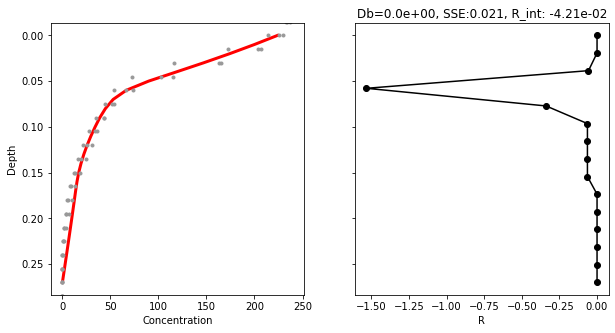

In [8]:
## Plot for inspection
# =================
ech = 'F2'
X, PA, phi, Ds, Db, BC = get_model_params(df, ech)
Db = Db_dict[ech]
K = phi*(Ds*fac+Db)
C_gt, X_gt = get_ground_truth(df, ech)
R = R_dict[ech]
temp = df[df['Echantillon']==ech]

fig, ax = plt.subplots(1,2,figsize=[10,5],sharey=True)
pad = .05*(X[0]-X[-1])
plt.ylim(X[-1]-pad, X[0]+pad)
plt.sca(ax[0])
plt.plot(C_dict[ech],X,'-r',lw=3)
plt.plot(temp['Concentration'],temp['Depth_cm'],'.',c=[.6,.6,.6])
plt.ylabel('Depth')
plt.xlabel('Concentration')
plt.sca(ax[1])
x_R = np.linspace(X[0], X[-1], len(R_opt))
plt.plot(R_dict[ech],x_R,'-ok')
plt.xlabel('R')
R_int = np.sum(R_dict[ech]*(x_R[1]-x_R[0]))
plt.title(f'Db={Db:.1e}, SSE:{SSE_dict[ech]:.2}, R_int: {R_int:.2e}')


## 6.2. Print r^2 values

In [9]:
r_sq_dict = {}
for ech in list_echantillon:
    X, PA, phi, Ds, Db, BC = get_model_params(df, ech)
    Db = Db_dict[ech]
    K = phi*(Ds*fac+Db)
    C_gt, X_gt = get_ground_truth(df, ech)
    R = R_dict[ech]
    C = C_dict[ech]

    f = interp1d(X, C)
    C_interp = f(X_gt)

    r_sq_dict[ech] = r2_score(C_gt, C_interp)
    display(f"{ech}: r^2= {r_sq_dict[ech]}")

'B2: r^2= 0.9943457069918992'

'C4: r^2= 0.9926260326240426'

'G1: r^2= 0.994668696359877'

'H4: r^2= 0.9964469042135726'

'E1: r^2= 0.9972283296524683'

'F4: r^2= 0.9982635358117559'

'K3: r^2= 0.9972083233348669'

'L3: r^2= 0.9989562154665019'

'A2: r^2= 0.9973092551032654'

'C1: r^2= 0.9921522868361188'

'H1: r^2= 0.9982285537735167'

'I4: r^2= 0.9930272498453144'

'H3: r^2= 0.9980984332942375'

'I2: r^2= 0.9992984820853895'

'A1: r^2= 0.9988644775522691'

'C3: r^2= 0.9971605492841806'

'J4: r^2= 0.9743025768834843'

'K2: r^2= 0.993716249556044'

'D2: r^2= 0.9960183473534299'

'F2: r^2= 0.9813097889461038'

'G2: r^2= 0.998766832328704'

'I1: r^2= 0.9907634352131797'

'A3: r^2= 0.9865645347933425'

'B3: r^2= 0.9987880973382962'

'H2: r^2= 0.9964786950980404'

'G4: r^2= 0.99848555783539'

'C2: r^2= 0.9666524383903234'

'B1: r^2= 0.998205917180122'

'L4: r^2= 0.9969967464961978'

'J3: r^2= 0.9950133064316704'

'D4: r^2= 0.9978633478953608'

'E2: r^2= 0.9948842311257151'

'I3: r^2= 0.9997105653107713'

'G3: r^2= 0.9968754456848664'

'A4: r^2= 0.9946469272572633'

'B4: r^2= 0.9975299998058523'

'J2: r^2= 0.998153260679065'

'L1: r^2= 0.978178256318954'

'D3: r^2= 0.9851360267056883'

'E4: r^2= 0.9972236627919897'

'K4: r^2= 0.9979335923866842'

'L2: r^2= 0.999342374492076'

'E3: r^2= 0.9930299624193341'

'F1: r^2= 0.9921902275850125'

'J1: r^2= 0.998258285023416'

'K1: r^2= 0.9946389423947385'

'F3: r^2= 0.9985815638891195'

'D1: r^2= 0.9924308276961853'

'G5: r^2= 0.999185683420783'

'H5: r^2= 0.999255310247249'

'C5: r^2= 0.9963634506152402'

'B5: r^2= 0.9996317643774364'

'L5: r^2= 0.998615655062722'

'K5: r^2= 0.9992588458526821'

'F5: r^2= 0.9987338525163908'

'E5: r^2= 0.9974722398744829'

'I5: r^2= 0.9927284550986863'

'J5: r^2= 0.9950275454138369'

'A5: r^2= 0.9984382550863319'

'D5: r^2= 0.9991506052861421'

## 6.3. Plot surface fluxes

<AxesSubplot:xlabel='R_int'>

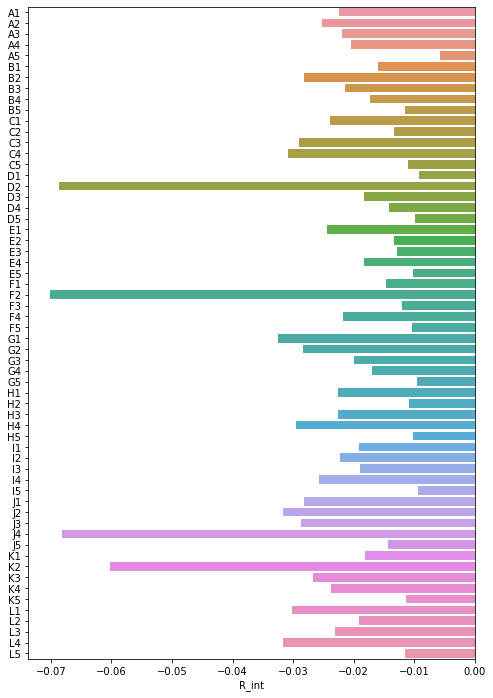

In [10]:
R_int = {}
for ech in list_echantillon:
    R = R_dict[ech]
    x_R = np.linspace(X[0], X[-1], len(R))
    R_int[ech] = np.sum(R_dict[ech]*(x_R[1]-x_R[0]))
R_int_df = pd.DataFrame.from_dict(R_int,orient='index',columns=['R_int'])
R_int_df.sort_index(inplace=True)
fig = plt.figure(figsize=[8,12])
sns.barplot(data=R_int_df,y=R_int_df.index, x='R_int')

## 7. Write results to file

In [11]:
# Output

out_df = pd.DataFrame(columns=['Echantillon','Type','Value','Depth_cm'])
for i, ech in enumerate(list_echantillon):
    ech_dict_Db = {}
    for ech in [ech]:
        ech_dict_Db['Echantillon'] = ech
        ech_dict_Db['Type'] = ['Db','SSE', 'R_int', 'r^2']
        ech_dict_Db['Value'] = [Db_dict[ech], SSE_dict[ech], R_int[ech], r_sq_dict[ech]]
        ech_dict_Db['Depth_cm'] = [np.nan, np.nan, np.nan, np.nan]

    ech_dict_R = {}
    for ech in [ech]:
        ech_dict_R['Echantillon'] = ech
        ech_dict_R['Type'] = 'R'
        ech_dict_R['Value'] = R_dict[ech]
        ech_dict_R['Depth_cm'] = np.linspace(X[0], X[-1], len(R_dict[ech]))

    ech_dict_C = {}
    for ech in [ech]:
        X, PA, phi, Ds, Db, BC = get_model_params(df, ech)
        ech_dict_C['Echantillon'] = ech
        ech_dict_C['Type'] = 'C'
        ech_dict_C['Value'] = C_dict[ech]
        ech_dict_C['Depth_cm'] = X
    
    
    out_df = pd.concat([out_df, pd.DataFrame.from_dict(ech_dict_Db)])        
    out_df = pd.concat([out_df, pd.DataFrame.from_dict(ech_dict_R )])
    out_df = pd.concat([out_df, pd.DataFrame.from_dict(ech_dict_C )])


out_df.tail()

,Echantillon,Type,Value,Depth_cm
41,D5,C,4.209375,0.41
42,D5,C,2.740927,0.42
43,D5,C,1.629117,0.43
44,D5,C,0.755116,0.44
45,D5,C,0.000000,0.45


In [12]:
# Write file
out_df.to_csv(f"./output.csv")